In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from matplotlib.colors import LinearSegmentedColormap

import sys
sys.path.insert(0, '../modules/')
import model
import utils

In [2]:
def h(f, xi):
    return f * xi / (f + 1)

In [3]:
# Parameters of the dynamics
NPatch = 60
NSpec = 2
Nsteps = 10000
Ngrid = 100
dt = 1e-1
# cvec = np.ones((NSpec, NPatch))
xi = 1
f1 = 1
f2 = 2.5

xi1 = xi
xi2 = xi

In [4]:
colorsSp1 = "#9c4747"
colorsSp2 = "#426d8b"
cmSp1 = plt.get_cmap("Blues")
cmSp2 = plt.get_cmap("Reds")

combined_colors = np.vstack((cmSp1(np.linspace(0, 1, 1000)), cmSp2(np.linspace(0, 1, 1000))))
combined_cm = LinearSegmentedColormap.from_list("Custom", combined_colors, N=1000)

# Grid

### Effective kernel

In [5]:
NPatch = 100
net_RI = nx.grid_graph((int(np.sqrt(NPatch)), int(np.sqrt(NPatch))), periodic=True)
kernel_RI1 = model.find_effective_kernel(f1, xi1, net_RI)
kernel_RI2 = model.find_effective_kernel(f2, xi2, net_RI)
kernel_RI = np.stack((kernel_RI1, kernel_RI2))
lambda_RI1 = model.find_metapopulation_capacity(kernel_RI1, net_RI, f1, xi1)
lambda_RI2 = model.find_metapopulation_capacity(kernel_RI2, net_RI, f2, xi2)
lambda_RI1, lambda_RI2

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/ppadmana/Library/CloudStorage/Dropbox/Code/CoexMetacomm/notebooks/../modules/model.py:71: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 2, 'F', False, aligned=True))
  effective_coupling = np.dot(cNormCoupling, adj_matrix.T)*xi*f/(1+f)


(1.9999999999999956, 2.8571428571428434)

In [6]:
Ngrid = 200
llamb = max(lambda_RI1, lambda_RI2)
deltae = 1.0 / Ngrid
e1_arr = np.linspace(0.0, 3.5, Ngrid)
e2_arr = np.linspace(0.0, 3.5, Ngrid)
epsvec = np.ones((NSpec, kernel_RI1.shape[0])) * 0

In [7]:
run = False
if run:
    rho_grid_RI = model.find_statpop_escan_2S(e1_arr, e2_arr, net_RI, net_RI, Nsteps, dt, f1, f2, xi1, xi2)
    np.savez_compressed("../data/plot_draft_data/Figure2/rho_grid_2d.npz", rho_grid_RI=rho_grid_RI, e1_arr=e1_arr, e2_arr=e2_arr)
else:
    rho_grid_RI = np.load("../data/plot_draft_data/rho_grid_2d.npz")["rho_grid_RI"]
    e1_arr = np.load("../data/plot_draft_data/rho_grid_2d.npz")["e1_arr"]
    e2_arr = np.load("../data/plot_draft_data/rho_grid_2d.npz")["e2_arr"]

In [8]:
threshold = 1e-4
origsp1array = np.mean(rho_grid_RI[:, :, 0, :], axis=-1).T
origsp2array = np.mean(rho_grid_RI[:, :, 1, :], axis=-1).T

sp1array = np.mean(rho_grid_RI[:, :, 0, :], axis=-1).T

sp1array[sp1array<threshold] = 0
sp1array[sp1array>threshold] = sp1array[sp1array>threshold] - 1

sp2array = np.mean(rho_grid_RI[:, :, 1, :], axis=-1).T
sp2array[sp2array<threshold] = 0
sp2array[sp1array>threshold] = sp2array[sp1array>threshold] +1

combined_sp_array = sp1array + sp2array
combined_sp_array[np.where(origsp1array+origsp2array<threshold)] = -1

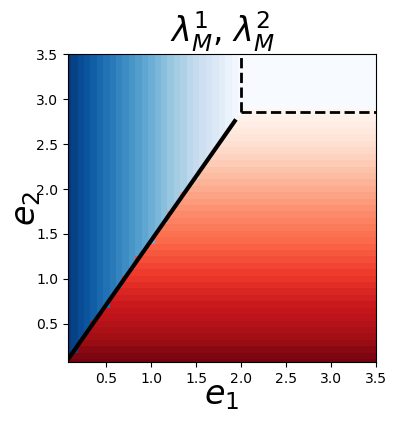

In [9]:
fig, ax = plt.subplots(figsize=(4,4))

ax.set_aspect('equal')
ax.plot(np.full(np.sum(e2_arr>lambda_RI2), lambda_RI1), e2_arr[e2_arr>lambda_RI2 ],color="k", lw=2, ls="--")
ax.plot(e1_arr[e1_arr>lambda_RI1], np.full(np.sum(e1_arr>lambda_RI1), lambda_RI2),color="k", lw=2, ls="--")

ax.pcolormesh(e1_arr,e2_arr,(combined_sp_array), cmap=combined_cm, lw=1,
              rasterized = True)
ax.plot(e1_arr[e1_arr<lambda_RI1], e1_arr[e1_arr<lambda_RI1] * h(f2, xi2) / h(f1, xi1) / 1.,"k",lw=3)


ax.set_xlim(e1_arr[1], 3.5)
ax.set_ylim(e2_arr[1], 3.5)

ax.set_xlabel(r"$e_1$", labelpad = -5, fontsize = 24)
ax.set_ylabel(r"$e_2$", labelpad = -5, fontsize = 24)
ax.set_title(r"$\lambda_M^1$, $\lambda_M^2$", fontsize = 24)
plt.show()

In [10]:
th = 1e-3
rho1 = rho_grid_RI[:, :, 0, :]
rho2 = rho_grid_RI[:, :, 1, :]
b_rho1_RI = np.digitize(np.sum(rho1, axis=-1), [th])
b_rho2_RI = np.digitize(np.sum(rho2, axis=-1), [th])
exist_RI = b_rho1_RI + b_rho2_RI
coexist_RI = b_rho1_RI * b_rho2_RI
indeces = np.where(coexist_RI > 0)
coex_here = np.transpose((e1_arr[indeces[0]], e2_arr[indeces[1]]))

coex_here[:, 1] / coex_here[:, 0]
omega = h(f2, xi2) / h(f1, xi1)
omega_num_RI = np.mean(np.sum(kernel_RI2, axis=0) / np.sum(kernel_RI1, axis=1))

/var/folders/rp/4969vws91431vgg3v1nxd3bw0000gp/T/ipykernel_22210/3375430730.py:11: RuntimeWarning: invalid value encountered in divide
  coex_here[:, 1] / coex_here[:, 0]


In [15]:
dt = 0.001
nrunsteps = int(2e6)
e1select = 0.25
e2select = e1select * h(f2, xi2) / h(f1, xi1) /1.0
evec = np.stack((np.full(NPatch, e1select), np.full(NPatch, e2select)))

times = np.linspace(dt, nrunsteps*dt, nrunsteps)
cvec = np.stack((np.full(NPatch, 1), np.full(NPatch, 1)))    

simulate = False

if simulate:
    rho0_high = np.full((2, NPatch),0.8)
    rho0_high[0] += np.random.random(NPatch)*0.1
    rho0_high[1] -= np.random.random(NPatch)*0.1
    this_rho_high_Grid = model.simulate_S(2, NPatch, nrunsteps, dt, kernel_RI, cvec, evec, rho0_high)

    rho0_low = np.full((2, NPatch),0.1)
    rho0_low[0] += np.random.random(NPatch)*0.1
    rho0_low[1] -= np.random.random(NPatch)*0.1
    this_rho_low_Grid = model.simulate_S(2, NPatch, nrunsteps, dt, kernel_RI, cvec, evec, rho0_low)

    this_rho_high_Grid_sp1 = np.mean(this_rho_high_Grid[:, 0, :], axis=-1)
    this_rho_high_Grid_sp2 = np.mean(this_rho_high_Grid[:, 1, :], axis=-1)
    this_rho_low_Grid_sp1 = np.mean(this_rho_low_Grid[:, 0, :], axis=-1)
    this_rho_low_Grid_sp2 = np.mean(this_rho_low_Grid[:, 1, :], axis=-1)

    rhostat_high_Grid_sp1 = this_rho_high_Grid[-1, 0, :]
    rhostat_high_Grid_sp2 = this_rho_high_Grid[-1, 1, :]
    rhostat_low_Grid_sp1 = this_rho_low_Grid[-1, 0, :]
    rhostat_low_Grid_sp2 = this_rho_low_Grid[-1, 1, :]

    np.save("../data/plot_draft_data/Figure2/rhomean_high_grid_sp1.npy", this_rho_high_Grid_sp1)
    np.save("../data/plot_draft_data/Figure2/rhomean_high_grid_sp2.npy", this_rho_high_Grid_sp2)
    np.save("../data/plot_draft_data/Figure2/rhomean_low_grid_sp1.npy", this_rho_low_Grid_sp1)
    np.save("../data/plot_draft_data/Figure2/rhomean_low_grid_sp2.npy", this_rho_low_Grid_sp2)

    np.save("../data/plot_draft_data/rhostat_high_Grid_sp1.npy", rhostat_high_Grid_sp1)
    np.save("../data/plot_draft_data/rhostat_high_Grid_sp2.npy", rhostat_high_Grid_sp2)
    np.save("../data/plot_draft_data/rhostat_low_Grid_sp1.npy", rhostat_low_Grid_sp1)
    np.save("../data/plot_draft_data/rhostat_low_Grid_sp2.npy", rhostat_low_Grid_sp2)

else:
    this_rho_high_Grid_sp1 = np.load("../data/plot_draft_data/Figure2/rhomean_high_grid_sp1.npy")
    this_rho_high_Grid_sp2 = np.load("../data/plot_draft_data/Figure2/rhomean_high_grid_sp2.npy")
    this_rho_low_Grid_sp1 = np.load("../data/plot_draft_data/Figure2/rhomean_low_grid_sp1.npy")
    this_rho_low_Grid_sp2 = np.load("../data/plot_draft_data/Figure2/rhomean_low_grid_sp2.npy")

    rhostat_high_Grid_sp1 = np.load("../data/plot_draft_data/rhostat_high_Grid_sp1.npy")
    rhostat_high_Grid_sp2 = np.load("../data/plot_draft_data/rhostat_high_Grid_sp2.npy")
    rhostat_low_Grid_sp1 = np.load("../data/plot_draft_data/rhostat_low_Grid_sp1.npy")
    rhostat_low_Grid_sp2 = np.load("../data/plot_draft_data/rhostat_low_Grid_sp2.npy")

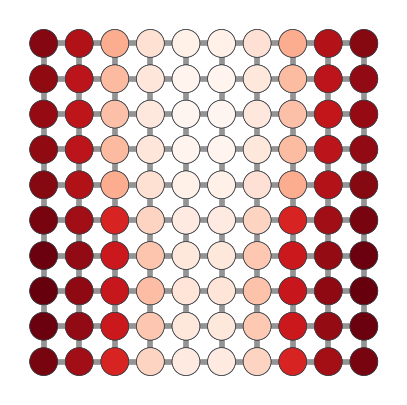

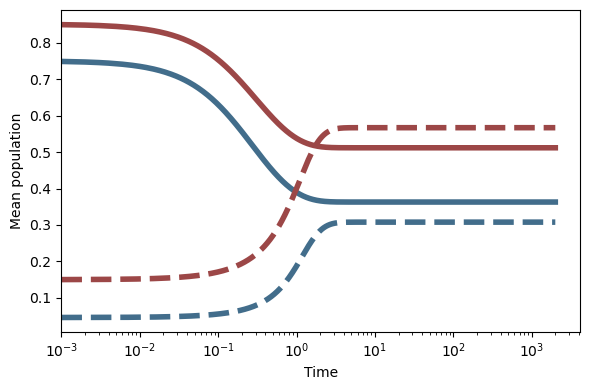

In [16]:
fig,ax = plt.subplots(figsize=(5 ,5))

pos_grid = {(x,y):(y,-x) for x,y in net_RI.nodes()}

nx.draw_networkx_nodes(net_RI, pos=pos_grid, node_size=400, node_color = rhostat_high_Grid_sp1.reshape(10,10), ax=ax,cmap=cmSp1,
                        edgecolors = "#343a40", linewidths = 0.5)
nx.draw_networkx_nodes(net_RI, pos=pos_grid, node_size=400, node_color = rhostat_high_Grid_sp2.reshape(10,10), ax=ax,cmap=cmSp2,
                        edgecolors = "#343a40", linewidths = 0.5)
nx.draw_networkx_edges(net_RI, pos=pos_grid, edge_color='gray', ax=ax,width=4, alpha = 0.6)

ax.set_frame_on(False)
plt.show()

fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(times,this_rho_high_Grid_sp1,label='sp1',color=colorsSp1,lw=4)
ax.plot(times,this_rho_high_Grid_sp2,label='sp2',color=colorsSp2,lw=4)

ax.plot(times,this_rho_low_Grid_sp1,label='sp1',color=colorsSp1,ls='--',lw=4)
ax.plot(times,this_rho_low_Grid_sp2,label='sp2',color=colorsSp2,ls='--',lw=4)

ax.set_xlabel('Time')
ax.set_ylabel('Mean population')

ax.set_xscale('log')
ax.set_xlim(dt,)
fig.tight_layout()

# plt.savefig("../plots/fig2_drafts/grid_central_manifold.svg",format='svg')
plt.show()

# Erdos Renyi

In [17]:
p_ER = 4/NPatch
net_ER = nx.erdos_renyi_graph(NPatch, p_ER)
while(not nx.is_connected(net_ER)):
    net_ER = nx.erdos_renyi_graph(NPatch, p_ER)
layout  = nx.kamada_kawai_layout(net_ER)

In [18]:
xi1_ER = lambda_RI1 * h(f1, xi1)/0.973
xi2_ER = lambda_RI2 * h(f2, xi2)/1.925
kernel_ER1 = model.find_effective_kernel(f1, xi1_ER, net_ER)
kernel_ER2 = model.find_effective_kernel(f2, xi2_ER, net_ER)
lambda_ER1 = model.find_metapopulation_capacity(kernel_ER1, net_ER, f1, xi1_ER)
lambda_ER2 = model.find_metapopulation_capacity(kernel_ER2, net_ER, f2, xi2_ER)
kernel_ER = np.stack((kernel_ER1, kernel_ER2))
lambda_ER1, lambda_ER2

(2.204355233527281, 3.1673439290062233)

In [19]:
Ngrid = 200
Nsteps = 10000
llamb = max(lambda_ER1, lambda_ER2)
deltae = 1.0 / Ngrid
e1_arr = np.linspace(0.0, 1.1 * llamb, Ngrid)
e2_arr = np.linspace(0.0, 1.1 * llamb, Ngrid)
# epsvec = np.ones((NSpec, NPatch)) * 0.2
deltae

0.005

In [20]:
run = False
if run:
    rho_grid_ER = model.find_statpop_escan_2S(e1_arr, e2_arr, net_ER,net_ER, Nsteps, dt, f1, f2, xi1_ER, xi2_ER)
    np.savez_compressed("../data/plot_draft_data/Figure2/rho_grid_ER_2d.npz", rho_grid_ER=rho_grid_ER, e1_arr=e1_arr, e2_arr=e2_arr)
else:
    rho_grid_ER = np.load("../data/plot_draft_data/rho_grid_ER_2d.npz")["rho_grid_ER"]
    e1_arr = np.load("../data/plot_draft_data/rho_grid_ER_2d.npz")["e1_arr"]
    e2_arr = np.load("../data/plot_draft_data/rho_grid_ER_2d.npz")["e2_arr"]

In [21]:
th = 1
rho1_ER = rho_grid_ER[:, :, 0, :]
rho2_ER = rho_grid_ER[:, :, 1, :]
b_rho1_ER = np.digitize(np.sum(rho1_ER, axis=-1), [th])
b_rho2_ER = np.digitize(np.sum(rho2_ER, axis=-1), [th])
exist_ER = b_rho1_ER + b_rho2_ER
coexist_ER = b_rho1_ER * b_rho2_ER
indeces = np.where(coexist_ER > 0)
z1 = np.mean(np.sum(kernel_ER1, axis=0))
z2 = np.mean(np.sum(kernel_ER2, axis=0))
coex_here = np.transpose((e1_arr[indeces[0]], e2_arr[indeces[1]]))
omega_num_ER = np.mean(np.sum(kernel_ER2, axis=0) / np.sum(kernel_ER1, axis=1))
omega_num_ER2 = np.mean(np.sum(kernel_ER1, axis=0) / np.sum(kernel_ER2, axis=1))

In [22]:
dt = 0.001
nrunsteps = int(2e6)
ii, jj = indeces[0], indeces[1]
i, j = ii[0], jj[0]

N = NPatch

evec = np.stack((np.full(N, e1select), np.full(N, e1select * z2/z1 /1.0)))
# evec = np.stack((np.full(N, 0), np.full(N, 0)))

times = np.linspace(dt, nrunsteps*dt, nrunsteps)
cvec = np.stack((np.full(N, 1), np.full(N, 1)))    

simulate = False

if simulate:

    rho0_high = np.full((2, NPatch), 0.8)
    rho0_high[0] += np.random.random(NPatch)*0.1
    rho0_high[1] -= np.random.random(NPatch)*0.1
    this_rho_high_ER = model.simulate_S(2, NPatch, nrunsteps, dt, kernel_ER, cvec, evec, rho0_high)

    rho0_low = np.full((2, NPatch), 0.1)
    rho0_low[0] += np.random.random(NPatch)*0.1
    rho0_low[1] -= np.random.random(NPatch)*0.1
    this_rho_low_ER = model.simulate_S(2, NPatch, nrunsteps, dt, kernel_ER, cvec, evec, rho0_low)

    this_rho_high_ER_sp1 = np.mean(this_rho_high_ER[:, 0, :], axis=-1)
    this_rho_high_ER_sp2 = np.mean(this_rho_high_ER[:, 1, :], axis=-1)
    this_rho_low_ER_sp1 = np.mean(this_rho_low_ER[:, 0, :], axis=-1)
    this_rho_low_ER_sp2 = np.mean(this_rho_low_ER[:, 1, :], axis=-1)

    rhostat_high_ER_sp1 = this_rho_high_ER[-1, 0, :]
    rhostat_high_ER_sp2 = this_rho_high_ER[-1, 1, :]
    rhostat_low_ER_sp1 = this_rho_low_ER[-1, 0, :]
    rhostat_low_ER_sp2 = this_rho_low_ER[-1, 1, :]

    np.save("../data/plot_draft_data/Figure2/rhomean_high_ER_sp1.npy", this_rho_high_ER_sp1)
    np.save("../data/plot_draft_data/Figure2/rhomean_high_ER_sp2.npy", this_rho_high_ER_sp2)
    np.save("../data/plot_draft_data/Figure2/rhomean_low_ER_sp1.npy", this_rho_low_ER_sp1)
    np.save("../data/plot_draft_data/Figure2/rhomean_low_ER_sp2.npy", this_rho_low_ER_sp2)

    np.save("../data/plot_draft_data/Figure2/rhostat_high_ER_sp1.npy", rhostat_high_ER_sp1)
    np.save("../data/plot_draft_data/Figure2/rhostat_high_ER_sp2.npy", rhostat_high_ER_sp2)
    np.save("../data/plot_draft_data/Figure2/rhostat_low_ER_sp1.npy", rhostat_low_ER_sp1)
    np.save("../data/plot_draft_data/Figure2/rhostat_low_ER_sp2.npy", rhostat_low_ER_sp2)

else:
    this_rho_high_ER_sp1 = np.load("../data/plot_draft_data/Figure2/rhomean_high_ER_sp1.npy")
    this_rho_high_ER_sp2 = np.load("../data/plot_draft_data/Figure2/rhomean_high_ER_sp2.npy")
    this_rho_low_ER_sp1 = np.load("../data/plot_draft_data/Figure2/rhomean_low_ER_sp1.npy")
    this_rho_low_ER_sp2 = np.load("../data/plot_draft_data/Figure2/rhomean_low_ER_sp2.npy")

    rhostat_high_ER_sp1 = np.load("../data/plot_draft_data/Figure2/rhostat_high_ER_sp1.npy")
    rhostat_high_ER_sp2 = np.load("../data/plot_draft_data/Figure2/rhostat_high_ER_sp2.npy")
    rhostat_low_ER_sp1 = np.load("../data/plot_draft_data/Figure2/rhostat_low_ER_sp1.npy")
    rhostat_low_ER_sp2 = np.load("../data/plot_draft_data/Figure2/rhostat_low_ER_sp2.npy")

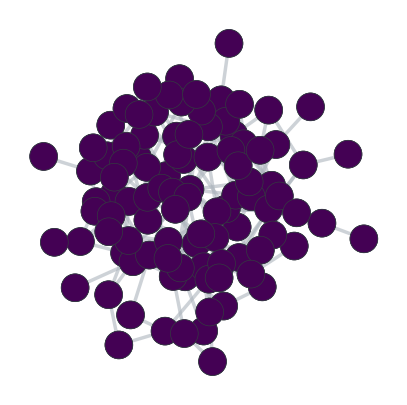

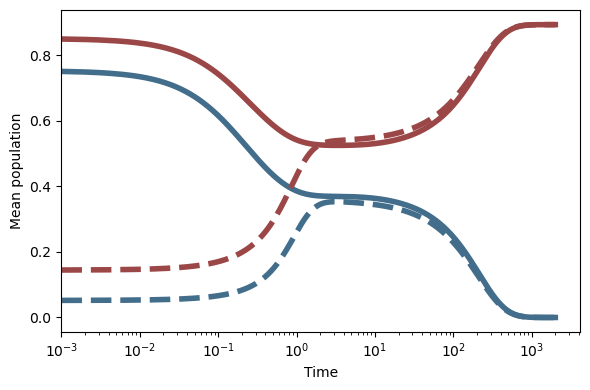

In [33]:
fig,ax = plt.subplots(figsize=(5 ,5))

vmax = np.max([rhostat_high_ER_sp1.max(), rhostat_high_ER_sp2.max()])
vmin = np.min([rhostat_high_ER_sp1.min(), rhostat_high_ER_sp2.min()])

nx.draw_networkx_nodes(net_ER, pos=layout, node_size=400, node_color = rhostat_high_ER_sp1.reshape(10,10), ax=ax,cmap=cmSp1,
                        edgecolors = "#343a40", linewidths = 0.5
                       )
nx.draw_networkx_nodes(net_ER, pos=layout, node_size=400, node_color = rhostat_high_ER_sp2.reshape(10,10), ax=ax,
                        edgecolors = "#343a40", linewidths = 0.5,
                       vmax = vmax)
nx.draw_networkx_edges(net_ER, pos=layout, edge_color='#adb5bd', ax=ax, width=2.5, alpha = 0.6)

ax.set_frame_on(False)
plt.show()

fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(times, this_rho_high_ER_sp1, label='sp1',color=colorsSp1,lw=4)
ax.plot(times, this_rho_high_ER_sp2, label='sp2',color=colorsSp2,lw=4)

ax.plot(times, this_rho_low_ER_sp1, label='sp1',color=colorsSp1,ls='--',lw=4)
ax.plot(times, this_rho_low_ER_sp2, label='sp2',color=colorsSp2,ls='--',lw=4)

ax.set_xlabel('Time')
ax.set_ylabel('Mean population')

ax.set_xscale('log')
ax.set_xlim(dt,)
fig.tight_layout()

plt.show()